In [3]:
# </path/to>/build/bin/hipace <input>

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from openpmd_viewer import OpenPMDTimeSeries
from openpmd_viewer.addons import LpaDiagnostics
from scipy import constants

from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
sys.path.append('/Users/max/HiPACE/hipace/tools/')
import read_insitu_diagnostics as diag

plt.rc('text', usetex = True)
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = [10.0, 6.0]
plt.rcParams['font.size'] = 16
plt.style.use('classic')



d = 'none'
# d = 'behind'
# d = 'front'
# d = 'salameTest'

f = 'non-filament'
ts = LpaDiagnostics(f'/Users/max/HiPACE/recovery/{f}/h5/{d}/', check_all_files = True)

In [4]:
def customCMAP(names = ['RdBu', 'PuOr', 'PRGn', 'bwr', 'bwr_r', 'PuOr_r'], ncolors: int = 256):
    for cmap in names:
        color_array = plt.get_cmap(cmap)(range(ncolors))
        color_array[:,-1] = abs(np.linspace(-1.0, 1.0, ncolors))
        map_object = mcolors.LinearSegmentedColormap.from_list(name = cmap + 'T', colors = color_array)
        plt.register_cmap(cmap = map_object)

# customCMAP()

def skinDepth(ne):
    """
    Calculates plasma skin depth based off plasma electron density

    Parameters
    ----------
    ne : float
        plasma electron density (in cm^-3)
    
    Returns
    -------
    kp_inv : float
        plasma skin depth in m
    """

    wp = 1e-3 * np.sqrt((ne * constants.e**2) / (constants.epsilon_0 * constants.m_e)) # SI
    
    kp_inv = 1e-6 * constants.c / wp # m
    
    return kp_inv

def E0(ne: float) -> float:
    """
    Calculates the cold-nonrelativistic wave breaking field E0

    Parameters
    ----------
    ne : float
        plasma electron density (in cm^-3)
    
    Returns
    -------
    E0 : float
        cold-nonrelativistic wave breaking field (in V/m)
    """
    kp = skinDepth(ne) ** -1 # m^-1
    return constants.m_e * constants.c**2 * kp / constants.e # V/m

def GeV2P(pG: float) -> float:
    """
    Calculates momentum value for HiPACE++ input file from GeV/c value
    
    Parameters
    ----------
    pG : float
        momentum in GeV/c
    
    Returns
    -------
    p : float
        momentum in HiPACE++ input file units
    """
    pG *= 1e9 * constants.e / constants.c # 1 [GeV/c] = eV / (m/s) = kg m / s

    return pG / (constants.m_e * constants.c)

def getZ(E, info):
    """
    returns on-axis longitudinal slice of field
    """
    return E[:, len(info.x)//2].T

def getPlotData(iteration: int, recovery: bool) -> tuple:
    i = iteration

    ExmBy, info = ts.get_field(field = 'ExmBy', iteration = i)
    Ez = getZ(ts.get_field(field = 'Ez', iteration = i)[0], info)
    xd, zd = ts.get_particle(species = 'drive', iteration = i, var_list = ['x', 'z'])
    xw, zw, ww = ts.get_particle(species = 'witness', iteration = i, var_list = ['x', 'z', 'w'])
    if recovery:
        xr, zr, wr = ts.get_particle(species = 'recovery', iteration = i, var_list = ['x', 'z', 'w'])
    else:
        xr, zr, wr = np.zeros_like(xd), np.zeros_like(zd), np.zeros_like(xd)

    return ExmBy, info, Ez, xd, zd, xw, zw, ww, xr, zr, wr

def EDensitySim(n0, iteration: int, normalized: bool, xyz = False):
    """
    From HiPACE++ simulation (normalized input file)
    """
    
    i = iteration

    Ez, info = ts.get_field(field = 'Ez', iteration = i)
    ExmBy, _ = ts.get_field(field = 'ExmBy', iteration = i)
    EypBx, _ = ts.get_field(field = 'EypBx', iteration = i)
    By, _ = ts.get_field(field = 'By', iteration = i)
    Bx, _ = ts.get_field(field = 'Bx', iteration = i)
    Bz, _ = ts.get_field(field = 'Bz', iteration = i)

    if normalized:
        Ex = ExmBy + By
        Ey = EypBx - Bx
        u = E0(n0)**2 / 2 * constants.epsilon_0 * ((Ex**2 + Ey**2 + Ez**2) + (Bx**2 + By**2 + Bz**2)) # from normalized sim
    else:
        Ex = ExmBy + constants.c * By
        Ey = EypBx - constants.c * Bx
        u = 1 / 2 * (constants.epsilon_0 * (Ex**2 + Ey**2 + Ez**2) + 1 / constants.mu_0 * (Bx**2 + By**2 + Bz**2))
    
    if xyz:
        return info, u
    else:
        return u

def charge(q: float, ne = 1e23) -> float:
    """
    Calculates charge in Coulombs based off of normalized charge

    Parameters
    ----------
    q : float
        normalized charge
    ne : float
        plasma electron density (in m^-3).  Defaults to 1e23 m^-3

    Returns
    -------
    q0 * q : float
        charge in Coulombs
    """
    # n_b = Q/((2*pi)^(3/2)* std_x * std_y * std_z)
    
    q0 = constants.c**3 * constants.epsilon_0**(3/2) * constants.m_e**(3/2) / (np.sqrt(ne) * constants.e**2)
    
    return q0 * q

def bunchMask(iteration: int, recovery: bool) -> tuple:
    i = iteration
    _, info = ts.get_field(field = 'Ez', iteration = i, coord = 'z')
    zd = ts.get_particle(species = 'drive', iteration = i, var_list = ['z'])[0]
    zw = ts.get_particle(species = 'witness', iteration = i, var_list = ['z'])[0]

    driveMin, driveMax = min(zd), max(zd)
    witnessMin, witnessMax = min(zw), max(zw) # note that 'witness2' is spatially contained in 'witness'

    maskD = np.logical_and(driveMin <= info.z, info.z <= driveMax)
    maskW = np.logical_and(witnessMin <= info.z, info.z <= witnessMax)

    if recovery:
        zr = ts.get_particle(species = 'recovery', iteration = i, var_list = ['z'])[0]
        recoveryMin, recoveryMax = min(zr), max(zr)
        maskR = np.logical_and(recoveryMin <= info.z, info.z <= recoveryMax)
    else:
        maskR = np.zeros_like(maskD)

    return maskD, maskW, maskR

def insitu(insitu_path, recovery: bool):
    driveInsitu = diag.read_file(insitu_path + 'reduced_drive.0000.txt')
    witnessInsitu = diag.read_file(insitu_path + 'reduced_witness.0000.txt')

    if recovery:
        recoveryInsitu = diag.read_file(insitu_path + 'reduced_recovery.0000.txt')
    else:
        recoveryInsitu = np.zeros_like(driveInsitu)

    return driveInsitu, witnessInsitu, recoveryInsitu

def quickEfficiency(path: str, insitu_path: str, iteration: int, recovery: bool, check_files = False) -> float:
    """
    Calculates energy transfer efficiency from drive to witness bunch (only uses on-axis slices).

    Parameters
    ----------
    path : str
        path to output directory
    
    insitu_path : str
        path to insitu diagnostics file

    iteration : int, optional
        iteration number. Defaults to 0.
    
    check_files :bool, optional
        check all files in directory are of the same form. Defaults to False.

    Returns
    -------
    eta : float (in percent)
        energy transfer efficiency from drive to witness bunch
    """
    ts = LpaDiagnostics(path, check_all_files = check_files)

    i = iteration

    driveInsitu, witnessInsitu, recoveryInsitu = insitu(insitu_path, recovery)

    Qd_slices = diag.per_slice_charge(driveInsitu)[i]
    Qw_slices = diag.per_slice_charge(witnessInsitu)[i]
    Qr_slices = diag.per_slice_charge(recoveryInsitu)[i]

    Ez_raw, info = ts.get_field(field = 'Ez', iteration = i, coord = 'z')
    
    Ez = getZ(Ez_raw, info) # on-axis slice of Ez

    d = Ez @ Qd_slices
    w = Ez @ Qw_slices
    r = Ez @ Qr_slices

    eta = - ((w + r) / d) * 1e2 # percent

    return eta

def efficiency3D(path: str, insitu_path: str, iteration: int, recovery: bool, check_files = False) -> float:
    """
    Calculates energy transfer efficiency from drive to witness bunch (includes entire 3D domain in calculation).

    NOTE: `diagnostic.names = driver_diag witness_diag` must be set with xyz Ez field diagnostics enabled in order for this to work

    Parameters
    ----------
    path : str
        path to output directory
    
    insitu_path : str
        path to insitu diagnostics file

    iteration : int, optional
        iteration number. Defaults to 0.
    
    check_files :bool, optional
        check all files in directory are of the same form. Defaults to False.

    Returns
    -------
    eta : float (in percent)
        energy transfer efficiency from drive to witness bunch
    """
    
    ts = LpaDiagnostics(path, check_all_files = check_files)
    
    i = iteration

    driveInsitu, witnessInsitu, recoveryInsitu = insitu(insitu_path, recovery)

    z = diag.z_axis(driveInsitu)

    EzDrive, infoD = ts.get_field(field = 'Ez_driver_diag', iteration = i)
    EzWitness, infoW = ts.get_field(field = 'Ez_witness_diag', iteration = i)

    if recovery:
        EzRecovery, infoR = ts.get_field(field = 'Ez_recovery_diag', iteration = i)
        maskR = np.logical_and(z >= infoR.zmin, z <= infoR.zmax)
        EzR = np.array([np.mean(EzRecovery[i,:,:]) for i in range(EzRecovery.shape[0])])
        Qr_slices = diag.per_slice_charge(recoveryInsitu)[i][maskR]
        r = EzR @ Qr_slices
    else:
        r = 0

    # average Ez for each z-slice over each bunch
    EzD = np.array([np.mean(EzDrive[i,:,:]) for i in range(EzDrive.shape[0])])
    EzW = np.array([np.mean(EzWitness[i,:,:]) for i in range(EzWitness.shape[0])])

    maskD = np.logical_and(z >= infoD.zmin, z <= infoD.zmax)
    maskW = np.logical_and(z >= infoW.zmin, z <= infoW.zmax)

    Qd_slices = diag.per_slice_charge(driveInsitu)[i][maskD]
    Qw_slices = diag.per_slice_charge(witnessInsitu)[i][maskW]

    # print(Qd_slices.shape, Qw_slices.shape, Qr_slices.shape)
    # print(EzD.shape, EzW.shape)

    d = EzD @ Qd_slices
    w = EzW @ Qw_slices

    eta = - ((w + r) / d) * 1e2 # percent

    return eta

def getProfile(iteration: int, recovery: bool, plot = False):
    i = iteration
    maskD, maskW, maskR = bunchMask(iteration, recovery)

    Ez_raw, info = ts.get_field(field = 'Ez', iteration = i, coord = 'z')
    Ez = getZ(Ez_raw, info) # on-axis slice of Ez
    zd, wd = ts.get_particle(species = 'drive', iteration = i, var_list = ['z', 'w'])
    zw, ww = ts.get_particle(species = 'witness', iteration = i, var_list = ['z', 'w'])
    

    plt.close()
    plt.figure(figsize = (10, 6))
    plt.rcParams['agg.path.chunksize'] = 10000
    nD = plt.hist(zd, bins = len(Ez[maskD]), facecolor = 'r', linewidth = 0.2, weights = wd)[0]
    nW = plt.hist(zw, bins = (len(Ez[maskW])), facecolor = 'b', linewidth = 0.2, weights = ww)[0]
    if recovery:
        zr, wr = ts.get_particle(species = 'recovery', iteration = i, var_list = ['z', 'w'])
        nR = plt.hist(zr, bins = (len(Ez[maskR])), facecolor = 'g', linewidth = 0.2, weights = wr)[0]
    else:
        nR = 0
    plt.close()

    if plot:
        plt.plot(info.z[maskD], nD, 'r', alpha = .5)
        plt.plot(info.z[maskW], nW, 'r', alpha = .5)
        plt.plot(info.z[maskR], nR, 'r', alpha = .5)


    return nD, info.z[maskD], nW, info.z[maskW], nR, info.z[maskR]

def emittance(sigma_x, sigma_ux, normalized: bool, n0 = 0):
    """
    Calculates normalized emittance

    Parameters
    ----------
    normalized : bool
        If True, assumes sigma_x and sigma_ux are normalized by the skin depth and m_e*c, respectively.
    n0 : float
        Plasma density (in cm^-3)
    """

    if normalized:
        return sigma_x * skinDepth(n0) * sigma_ux # m rad
    else:
        return sigma_x * sigma_ux # m rad

def ux(eps_x, sigma_x, normalized: bool, n0 = 0):
    """
    Calculates normalized transverse momentum

    Parameters
    ----------
    eps_x : float
        normalized transverse emittance (in m rad)
    normalized : bool
        If True, assumes sigma_x is normalized by the skin depth
    n0 : float
        Plasma density (in cm^-3)
    
    Returns
    -------
    ux : float
        transverse momentum normalized to m_e*c
    """
    if normalized:
        return eps_x / (sigma_x * skinDepth(n0))
    else:
        return eps_x / sigma_x





In [80]:
i = 0

n0 = 7.8e15 # cm^-3
n = False
kp = skinDepth(n0)**-1
E_0 = E0(n0)

if d == 'none':
    r = False
else:
    r = True

ExmBy, info, Ez, xd, zd, xw, zw, ww, xr, zr, wr = getPlotData(iteration = i, recovery = r)
# profileD, xD, profileW, xW, profileR, xR = getProfile(iteration = i, recovery = r)

maskD, maskW, maskR = bunchMask(iteration = i, recovery = r)

rho = ts.get_field(field = 'rho', iteration = i, coord = 'z')[0]
jz_beam = ts.get_field(field = 'jz_beam', iteration = i, coord = 'z')[0]

u = EDensitySim(n0, iteration = i, xyz = False, normalized = n)

In [81]:
p = f'/Users/max/HiPACE/recovery/non-filament/h5/{d}/'
ip = f'/Users/max/HiPACE/recovery/non-filament/insitu/{d}/'

print(f'(Quick) Energy Transfer Efficiency : {quickEfficiency(p, ip, iteration = i, recovery = r):.2f} %')

(Quick) Energy Transfer Efficiency : 25.94 %


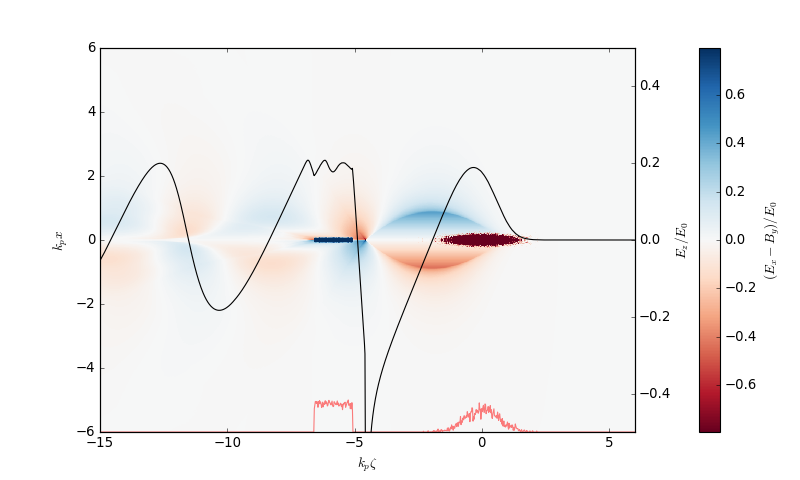

In [82]:
plt.close()
plt.figure(figsize = (10, 6))
ax = plt.axes()
im = plt.pcolormesh(kp * info.z, kp * info.x, ExmBy.T / E_0, cmap = 'RdBu') #, vmin = -1, vmax = 1)

# plt.scatter(kp * zd, kp * xd, s = .02, color = 'darkred', label = '$e^-$ Drive Bunch')
# plt.scatter(kp * zw, kp * xw, s = .02, color = 'b', label = '$e^+$ Witness Bunch')
# plt.scatter(kp * zr, kp * xr, s = .02, color = 'g', label = '$e^-$ Recovery Bunch')

plt.pcolormesh(kp * info.z, kp * info.x, jz_beam.T, cmap = 'RdBuT', vmin = -1e12, vmax = 1e12)
jzA = abs(jz_beam[:, len(info.x)//2])
plt.plot(kp * info.z, jzA / max(jzA) - 6, 'r', alpha = .5)

plt.xlim(-15, 6)
# plt.xlim(kp * info.zmin, kp * info.zmax)
# plt.ylim(info.xmin, info.xmax)
plt.ylim(-6, 6)
plt.ylabel('$k_px$')
plt.xlabel('$k_p\zeta$')

ax2 = plt.twinx()
ax2.plot(kp * info.z, Ez / E_0, color = 'black')
ax2.set_ylim(-.5, .5)
ax2.set_ylabel(r'$E_z/E_0$',  labelpad = 1) 

divider2 = make_axes_locatable(ax)
cax2 = divider2.append_axes("right", size = "4%", pad = .8)
divider3 = make_axes_locatable(ax2)
cax3 = divider3.append_axes("right", size = "4%", pad = .8)
cax3.remove()


cb2 = plt.colorbar(im, cax = cax2)
# cb2.formatter.set_useMathText(True)
# cb2.formatter.set_powerlimits((0, 0))
cb2.set_label(r'$(E_x - B_y)/E_0 $')
# plt.savefig('images/basic.png', dpi = 300, bbox_inches = 'tight')
plt.show()

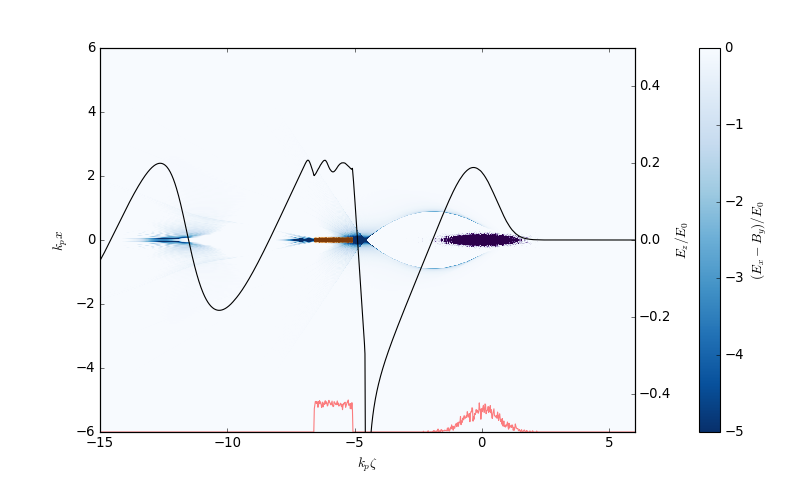

In [25]:
kp = skinDepth(n0)**-1
E_0 = E0(n0)

plt.close()
plt.figure(figsize = (10, 6))
ax = plt.axes()
im = plt.pcolormesh(kp * info.z, kp * info.x, rho.T / (constants.e * n0 * 1e6), cmap = 'Blues_r', vmin = -5, vmax = 0)

plt.pcolormesh(kp * info.z, kp * info.x, jz_beam.T, cmap = 'PuOr_rT', vmin = -1e12, vmax = 1e12)
jzA = abs(jz_beam[:, len(info.x)//2])
plt.plot(kp * info.z, jzA / max(jzA) - 6, 'r', alpha = .5)

plt.xlim(-15, 6)
# plt.xlim(kp * info.zmin, kp * info.zmax)
# plt.ylim(info.xmin, info.xmax)
plt.ylim(-6, 6)
plt.ylabel('$k_px$')
plt.xlabel('$k_p\zeta$')

ax2 = plt.twinx()
ax2.plot(kp * info.z, Ez / E_0, color = 'black')
ax2.set_ylim(-.5, .5)
ax2.set_ylabel(r'$E_z/E_0$',  labelpad = 1) 

divider2 = make_axes_locatable(ax)
cax2 = divider2.append_axes("right", size = "4%", pad = .8)
divider3 = make_axes_locatable(ax2)
cax3 = divider3.append_axes("right", size = "4%", pad = .8)
cax3.remove()


cb2 = plt.colorbar(im, cax = cax2)
# cb2.formatter.set_useMathText(True)
# cb2.formatter.set_powerlimits((0, 0))
cb2.set_label(r'$(E_x - B_y)/E_0 $')
# plt.savefig('images/basic.png', dpi = 300, bbox_inches = 'tight')
plt.show()